# Project: Investigate a Dataset - NICS Database and US Census Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

#### Overview

The data used in this project (orignally sourced from this [Github](https://github.com/BuzzFeedNews/nics-firearm-background-checks/blob/master/README.md)) comes from the FBI's National Instant Criminal Background Check System. This database is used to determine if an individual looking to buy firearms or explosives can legally do so. This data is generally considered to be the "best proxy for total gun sales in a given time period," although a one-to-one correlation cannot be made to a background check and a firearm purchase (jsvine [nics-firearm-background-checks](https://github.com/BuzzFeedNews/nics-firearm-background-checks/blob/master/README.md#notes-on-the-data))

In addition, data from [US census data](https://www.census.gov/) was pulled to supplement analysis. This data includes some raw number for each of the 50 US states for facts like "median gross rent" or "total retail sales per capita."

#### Columns

This data ranges from November 1998 to September 2017. 

**NICS Data**

|Column Name | Significance |
|------------|--------------|
| `month` | Month + year for reported data |
| `state` | US State/territory reporting the number of background checks (55 unique values) |
| `permit` | Initial issuance of a permit to own a firearm |
| `permit_recheck` | Re-validation of a permit to own a firearm |
| `handgun` | A short-stocked weapon designed to be fired with a single hand/any combination of parts from which something matching that description can be assembled |
| `long_gun` | A weapon intended to be fired from the shoulder, ejects one projectile per trigger pull |
| `other` | Neither handguns, nor rifles/shotguns. Includes frames, receivers, silencers, National Firearms Act firearms, or firearms with a pistol grip that expel a shotgun shell |
| `multiple` | Multiple types of firearms selected (`handgun`,`long_gun`,`other`) |
| `admin` | Administrative checks that are for other authorized uses of the NICS |
| `prepawn_*` | (*Note: `*` indicates the column exists for handguns, long guns, and other firearms*) Background check requested by an officially-licensed Federal Firearms Licensee (FFL) in response to transferee seeking to pledge/pawn a firearm |
| `redemption_*` | FFL check request in response to transferee seeking to regain possession of a plegded/pawned firearm |
| `returned_*` | Requested by law enforcement/criminal justice before returning a firearm to an individual to ensure it is not prohibited |
| `rentals_*` (does not include `other`)| FFL check request in response to prospective firearm transferees attempting to possess a firearm loaned/rented and used off premises of the business |
| `private_sale_*` | FFL check request on prospective firearm transferees attempting to buy a firearm from a seller that is not an officially licensed FFL (background check via proxy) |
| `return_to_seller_*` | The source data ([here](https://www.fbi.gov/file-repository/cjis/nics_firearm_checks_-_month_year_by_state_type.pdf/view)) offers the same description for `private_sale`. If I had to presume what this is, I believe it may be for returns from a purchaser to a private seller of a firearm. I am not sure, though, and that is likely incorrect. |
| `totals` | Sum of values for all of the previously listed columns (besides `month` and `state`) |

**Census Data**

This data uses what was collected for the 2010 US Census plus estimates for the US population in 2017.

|Column Name | Significance |
|------------|--------------|
| `Fact` | Description of the statistic data was gathered for. |
| `Fact Note`  | Elaboration on the fact's data, 3 different notes. |
| `Alabama`  | Metric based on responses gathered from Alabama residents. Dollar value, percentage, count, etc. |
| (remaining 49 states) | ... |

### Question(s) for Analysis

Once we have our data organized and usable, I'll work through the following questions:

1. Does median household income have a positive, negative, or no correlation with NICS background checks?

2.  What does that look like when the NICS data is broken out to the different firearm types (`handgun`, `other`, `long gun`). Is the disparity between the three types generally the same across all of the states? I would assume a state like Rhode Island has a significantly smaller `long gun` background check percentage that somewhere like Wyoming, where recreational hunting is much more prominent.
    - Do any other factors potentially have an influence?
      - Total population
      - Land area
      - Number of veterans

In [1380]:
# Import libraries and allow matplot lib inline backend usage of the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling


Here we will be looking at the datasets, characterizing them, then cleaning them.

### General Properties

In this section, we'll be perusing the data to see how "dirty" it is, as well as familiarize ourselves with it.

#### NICS Data

As with all of our data, we'll need to load it, this time by using the `pandas.read_csv()` method. We might as well take a peek at it, too, and see if anything sticks out as "dirty."

In [1381]:
df_nics = pd.read_csv('gun_data.csv')
df_nics.head(3)

month    state   permit  permit_recheck  handgun  long_gun  other  \
0  2017-09  Alabama  16717.0             0.0   5734.0    6320.0  221.0   
1  2017-09   Alaska    209.0             2.0   2320.0    2930.0  219.0   
2  2017-09  Arizona   5069.0           382.0  11063.0    7946.0  920.0   

   multiple  admin  prepawn_handgun  ...  returned_other  rentals_handgun  \
0       317    0.0             15.0  ...             0.0              0.0   
1       160    0.0              5.0  ...             0.0              0.0   
2       631    0.0             13.0  ...             0.0              0.0   

   rentals_long_gun  private_sale_handgun  private_sale_long_gun  \
0               0.0                   9.0                   16.0   
1               0.0                  17.0                   24.0   
2               0.0                  38.0                   12.0   

   private_sale_other  return_to_seller_handgun  return_to_seller_long_gun  \
0                 3.0                       0.0                        0.0   
1                 1.0                       0.0                        0.0   
2                 2.0                       0.0                        0.0   

   return_to_seller_other  totals  
0                     3.0   32019  
1                     0.0    6303  
2                     0.0   28394  

[3 rows x 27 columns]

One of the things I think I'd want to change is splitting the `month` column into one that is solely the month, and another for the year. It looks like it's a string, which won't be the easiest datatype to work with a date in.

In [1382]:
type(df_nics['month'][0])

str

After that, we should check if any rows are entirely null values or if we have any duplicates.

In [1383]:
print("Contains null rows:", df_nics.isnull().sum().all())
print("Contains duplicate rows:", df_nics.duplicated().any())

Contains null rows: False
Contains duplicate rows: False


Then, by using `.nunique()` we can see if any of the values for each column stick out or what we could use to inform our decisions. For example, I noticed that there are `55` values in the `state` column.

In [1384]:
df_nics.nunique()

month                          227
state                           55
permit                        5390
permit_recheck                 168
handgun                       7381
long_gun                      8350
other                         1226
multiple                      1387
admin                          499
prepawn_handgun                 90
prepawn_long_gun               133
prepawn_other                   16
redemption_handgun            1893
redemption_long_gun           2370
redemption_other                47
returned_handgun               237
returned_long_gun              113
returned_other                  34
rentals_handgun                  9
rentals_long_gun                 8
private_sale_handgun           152
private_sale_long_gun          136
private_sale_other              43
return_to_seller_handgun        17
return_to_seller_long_gun       17
return_to_seller_other           5
totals                       10218
dtype: int64

It looks like 5 of those values are territories or districts. If this data isn't going to be used at all for our analysis, it can probably just be removed.

They are:
- District of Columbia
- Virgin Islands
- Puerto Rico
- Guam
- Mariana Islands

In [1385]:
df_nics['state'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Mariana Islands', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

Using the `.info()` method against the NICS DataFrame shows that the data has a few concerning qualities.
- Of the total 12485 entries, only 4/27 columns lack null values.
  - Of my options for handling them (dropping, imputing, etc.), I am choosing to replace them with the value `0` so they don't have to be handled specially when I make the data type conversions mentioned in the next bullet point.
- There are some suboptimal choices for data types.
  - Nearly all of the numerical values are `float64`, but FFLs can't perform half of a background check, so there is no point in storing a decimal value if it will always be `.0`.

In [1386]:
df_nics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      12485 non-null  object 
 1   state                      12485 non-null  object 
 2   permit                     12461 non-null  float64
 3   permit_recheck             1100 non-null   float64
 4   handgun                    12465 non-null  float64
 5   long_gun                   12466 non-null  float64
 6   other                      5500 non-null   float64
 7   multiple                   12485 non-null  int64  
 8   admin                      12462 non-null  float64
 9   prepawn_handgun            10542 non-null  float64
 10  prepawn_long_gun           10540 non-null  float64
 11  prepawn_other              5115 non-null   float64
 12  redemption_handgun         10545 non-null  float64
 13  redemption_long_gun        10544 non-null  flo

#### Census Data

Now we'll load up the US Census data and run through a similar process in exploring the data's properties.

First, we'll see what it generally looks like.

In [1387]:
df_census = pd.read_csv('US_Census_Data.csv')
df_census.head(3)

Fact Fact Note    Alabama  \
0       Population estimates, July 1, 2016,  (V2016)       NaN  4,863,300   
1  Population estimates base, April 1, 2010,  (V2...       NaN  4,780,131   
2  Population, percent change - April 1, 2010 (es...       NaN      1.70%   

    Alaska    Arizona   Arkansas  California   Colorado Connecticut Delaware  \
0  741,894  6,931,071  2,988,248  39,250,017  5,540,545   3,576,452  952,065   
1  710,249  6,392,301  2,916,025  37,254,522  5,029,324   3,574,114  897,936   
2    4.50%      8.40%      2.50%       5.40%     10.20%       0.10%    6.00%   

   ... South Dakota Tennessee       Texas       Utah  Vermont   Virginia  \
0  ...       865454   6651194  27,862,596  3,051,217  624,594  8,411,808   
1  ...       814195   6346298  25,146,100  2,763,888  625,741  8,001,041   
2  ...        0.063     0.048      10.80%     10.40%   -0.20%      5.10%   

  Washington West Virginia  Wisconsin  Wyoming  
0  7,288,000     1,831,102  5,778,708  585,501  
1  6,724,545     1,853,011  5,687,289  563,767  
2      8.40%        -1.20%      1.60%    3.90%  

[3 rows x 52 columns]

Already, I can see that there are null values. In fact, at least 5 of the 85 "entries" do not show up under a column per `.info()`. I'm also not a huge fan of the states being their own column. The column names are capitalized, which isn't inherently a bad thing, however `Fact Note` has a space in the middle of it. 

I also see that all of the data types are `object`, which will need to be changed before the data can be analyzed.

If this were a database, I'd probably make the sacrifice of having 50 records per `Fact` so that the only colummns are `Fact`, `Fact Note`, `State`, and `Value/Quantity`. I'd then break out a few more tables for states, facts, and fact notes to get it to third normal form.

Having the states in separate columns means I can't group by `state` as gracefully, too, which may make some analytics and visuals awkward to make. Leaving it how it is now does simplify our lives, and the data should still be accessible. 

In [1388]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Fact            80 non-null     object
 1   Fact Note       28 non-null     object
 2   Alabama         65 non-null     object
 3   Alaska          65 non-null     object
 4   Arizona         65 non-null     object
 5   Arkansas        65 non-null     object
 6   California      65 non-null     object
 7   Colorado        65 non-null     object
 8   Connecticut     65 non-null     object
 9   Delaware        65 non-null     object
 10  Florida         65 non-null     object
 11  Georgia         65 non-null     object
 12  Hawaii          65 non-null     object
 13  Idaho           65 non-null     object
 14  Illinois        65 non-null     object
 15  Indiana         65 non-null     object
 16  Iowa            65 non-null     object
 17  Kansas          65 non-null     object
 18  Kentucky    

One of the outliers is `Fact Note`, as it has only 28 non-null values when there are 65 data points for each state and... 80 facts? We'll worry about that next. Anyway, should we care about the `Fact Note` column? What non-null values does it have in the first place?

In [1389]:
df_census['Fact Note'].value_counts()

Fact Note
(c)                                                                                                                                                                                                                                            6
(a)                                                                                                                                                                                                                                            5
Includes data not distributed by county.                                                                                                                                                                                                       5
(b)                                                                                                                                                                                                                                            1
Includes persons reporting

It looks like these are probably good caveats to consider before we draw conclusions, but they will not be useful for analysis of the data. I will be dropping `Fact Notes`

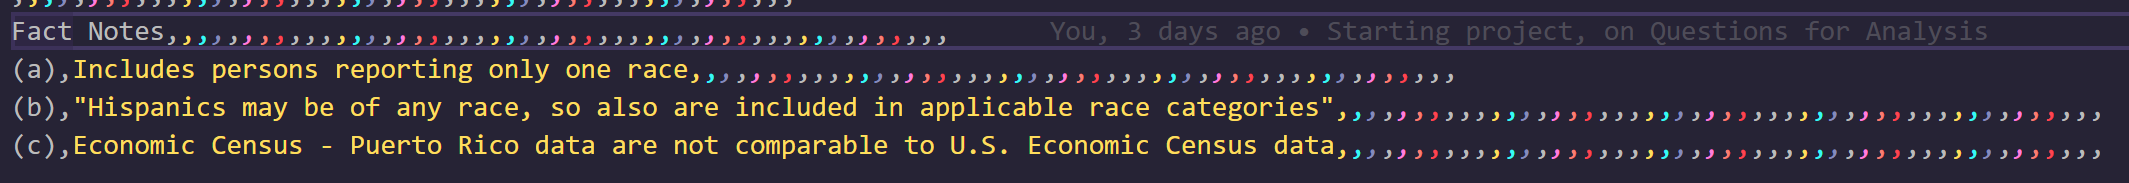

Now for those 80 facts, what's up with those?

In [1390]:
df_census['Fact'].unique()

array(['Population estimates, July 1, 2016,  (V2016)',
       'Population estimates base, April 1, 2010,  (V2016)',
       'Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)',
       'Population, Census, April 1, 2010',
       'Persons under 5 years, percent, July 1, 2016,  (V2016)',
       'Persons under 5 years, percent, April 1, 2010',
       'Persons under 18 years, percent, July 1, 2016,  (V2016)',
       'Persons under 18 years, percent, April 1, 2010',
       'Persons 65 years and over, percent,  July 1, 2016,  (V2016)',
       'Persons 65 years and over, percent, April 1, 2010',
       'Female persons, percent,  July 1, 2016,  (V2016)',
       'Female persons, percent, April 1, 2010',
       'White alone, percent, July 1, 2016,  (V2016)',
       'Black or African American alone, percent, July 1, 2016,  (V2016)',
       'American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)',
       'Asian alone, percent, July 1, 2016,  (V20

Some of these facts don't look the same as the others, such as `FN` and `Z`. Those are apparently value flags. I'm not sure they will be needed, so we'll probably drop them.

The last 17 items of the list are what we will want to remove.

In [1391]:
[df_census['Fact'] == "Z"]

[0     False
 1     False
 2     False
 3     False
 4     False
       ...  
 80    False
 81    False
 82    False
 83    False
 84     True
 Name: Fact, Length: 85, dtype: bool]

With the CSV column highlighter I have installed, we can look at all of the left-most grey text and know it falls under `Fact`. It looks like some notes or a key of sorts was thrown into the bottom of the data. We'll make sure those are all gone when we remove all null values.

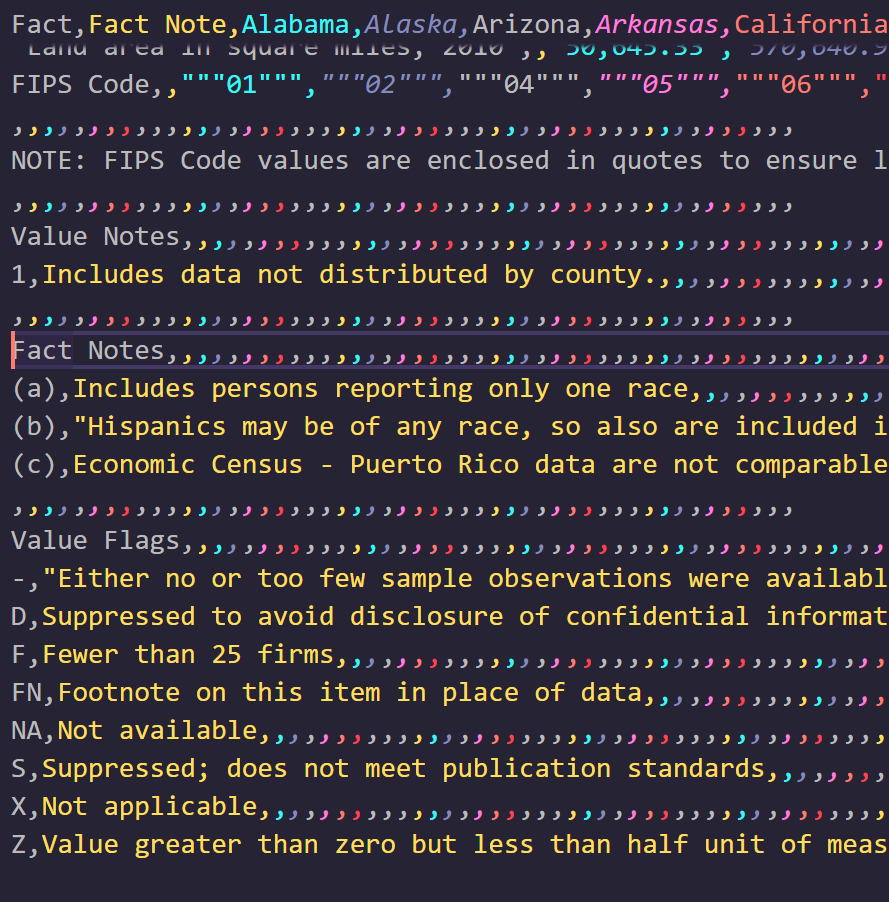

This quirk in the data also explains why we have null values in all of the state columns.

In [1392]:
df_census.tail()

Fact                                          Fact Note Alabama Alaska  \
80   FN             Footnote on this item in place of data     NaN    NaN   
81  NaN                                      Not available     NaN    NaN   
82    S    Suppressed; does not meet publication standards     NaN    NaN   
83    X                                     Not applicable     NaN    NaN   
84    Z  Value greater than zero but less than half uni...     NaN    NaN   

   Arizona Arkansas California Colorado Connecticut Delaware  ...  \
80     NaN      NaN        NaN      NaN         NaN      NaN  ...   
81     NaN      NaN        NaN      NaN         NaN      NaN  ...   
82     NaN      NaN        NaN      NaN         NaN      NaN  ...   
83     NaN      NaN        NaN      NaN         NaN      NaN  ...   
84     NaN      NaN        NaN      NaN         NaN      NaN  ...   

   South Dakota Tennessee Texas Utah Vermont Virginia Washington  \
80          NaN       NaN   NaN  NaN     NaN      NaN        NaN   
81          NaN       NaN   NaN  NaN     NaN      NaN        NaN   
82          NaN       NaN   NaN  NaN     NaN      NaN        NaN   
83          NaN       NaN   NaN  NaN     NaN      NaN        NaN   
84          NaN       NaN   NaN  NaN     NaN      NaN        NaN   

   West Virginia Wisconsin Wyoming  
80           NaN       NaN     NaN  
81           NaN       NaN     NaN  
82           NaN       NaN     NaN  
83           NaN       NaN     NaN  
84           NaN       NaN     NaN  

[5 rows x 52 columns]

We should probably double check if there are any null value in rows with actual data.

We can do that by:
1. Taking a slice of all of the states with `.iloc[2:end]`, plus the window of data we wish to analyze (0:64 exclusive).
2. Check if those values are not null (returns boolean)
  a. Check if all booleans are the same for each state's values with `.all()`
  b. Do the same, but for all states by nesting it all under another `.all()`

In [1393]:
# We'll use a similar technique to drop all of the data we don't want
(df_census.iloc[:, 2:][:64]).notnull().all().all()

np.True_

### Data Cleaning

 

#### NICS Data

To tidy up this data and get it how I plan to work with it, I will...
- Replacing all null values
  - One potential issue with this, besides that we don't _know_ `0` was reported for those fields instead of that data was just not collected, 
  
- Change all numeric types to `int32` to reduce memory usage.
- Drop 5 of the 55 values for `state`, leaving just the 50 US States. 
  - The US Census data for this project does not have anything for the territories that the NICS data has:
    - `['District of Columbia', 'Virgin Islands', 'Puerto Rico', 'Guam', 'Mariana Islands']`
- Split the current `month` string (`YYYY-mm`) into 2 separate columns of integers, one for `year` and the other for `month`.

In [1394]:
# Replace all null values with 0 to prevent errors when typecasting
df_nics.fillna(0, inplace=True)

Here, I'll be removing the `state` values in the NICS data that do not show up in the US Census Data.

In [1395]:
len(df_nics.state.unique())

55

There are 227 rows of data for each state. By removing the 5 territories, we should reduce our total number of records down to 11350.

In [1396]:
a = 12485 - (227 * 5)
print(a)

11350


In [1397]:
drop_states = ['District of Columbia', 'Virgin Islands', 'Puerto Rico', 'Guam', 'Mariana Islands']
df_nics['state'].value_counts()


state
Alabama                 227
Alaska                  227
Arizona                 227
Arkansas                227
California              227
Colorado                227
Connecticut             227
Delaware                227
District of Columbia    227
Florida                 227
Georgia                 227
Guam                    227
Hawaii                  227
Idaho                   227
Illinois                227
Indiana                 227
Iowa                    227
Kansas                  227
Kentucky                227
Louisiana               227
Maine                   227
Mariana Islands         227
Maryland                227
Massachusetts           227
Michigan                227
Minnesota               227
Mississippi             227
Missouri                227
Montana                 227
Nebraska                227
Nevada                  227
New Hampshire           227
New Jersey              227
New Mexico              227
New York                227
North Carolina

After dropping the locations we do not want, we can validate our results. Now we should validate that there are still 227 for each of the remaining 50 states.

In [1398]:
drop_states = ['District of Columbia', 'Virgin Islands', 'Puerto Rico', 'Guam', 'Mariana Islands']

for state in drop_states:
    drops = df_nics[df_nics['state'] == state].index

    for i in drops:
        df_nics.drop(index=i, inplace=True)

states = df_nics['state'].unique()

# Printing our validation results
print("Length is:", len(states))
print("All states still have 227 records:", (df_nics['state'].value_counts().values == 227).all())
print("Values are:", states)

Length is: 50
All states still have 227 records: True
Values are: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


In [1399]:
# Extract sequence of 4 digits, followed by a dash (not captured), then 2 digits
df_date = df_nics['month'].str.extract('(\d{4})-(\d{2})').astype('int16')

df_nics['year'] = df_date[0]
df_nics['month'] = df_date[1]

# This DataFrame will not be used later and can be destroyed
del df_date

Adding the new `year` column will append it to the end/right of the DataFrame.This is somewhat inconvenient when trying to view the data with `.head()`

In [1400]:
# To reorder, first we will make a list of columns with 'year' at the start
# Then we will use the .reindex() method to set the columns to the new order we want
df_nics = df_nics.reindex(columns=['year'] + list(df_nics.columns)[:-1])
df_nics.head(1)

year  month    state   permit  permit_recheck  handgun  long_gun  other  \
0  2017      9  Alabama  16717.0             0.0   5734.0    6320.0  221.0   

   multiple  admin  ...  returned_other  rentals_handgun  rentals_long_gun  \
0       317    0.0  ...             0.0              0.0               0.0   

   private_sale_handgun  private_sale_long_gun  private_sale_other  \
0                   9.0                   16.0                 3.0   

   return_to_seller_handgun  return_to_seller_long_gun  \
0                       0.0                        0.0   

   return_to_seller_other  totals  
0                     3.0   32019  

[1 rows x 28 columns]

In [1401]:
df_nics.tail(1)

year  month    state  permit  permit_recheck  handgun  long_gun  other  \
12484  1998     11  Wyoming     8.0             0.0     45.0      49.0    0.0   

       multiple  admin  ...  returned_other  rentals_handgun  \
12484         5    0.0  ...             0.0              0.0   

       rentals_long_gun  private_sale_handgun  private_sale_long_gun  \
12484               0.0                   0.0                    0.0   

       private_sale_other  return_to_seller_handgun  \
12484                 0.0                       0.0   

       return_to_seller_long_gun  return_to_seller_other  totals  
12484                        0.0                     0.0     107  

[1 rows x 28 columns]

The `head` and `tail` outputs are expected, showing us our most recent data and our oldest data, sorted alphabetically by `state` (hence, Alabama at the top and Wyoming at the bottom).

In [1402]:
numeric_cols = df_nics.columns.to_list()[3:]  # permit --> totals

# Re-cast columns to 32-bit integer
for col in numeric_cols:
    df_nics[col] = df_nics[col].astype('int32')

Now we should only have 1 string (`object`) column, 2 `int16` columns, and the rest should be `int32`.

In [1403]:
df_nics.dtypes.value_counts()

int32     25
int16      2
object     1
Name: count, dtype: int64

To recap, we:
- Replaced all null values with `0`.
- Dropped rows with `state` values that did not appear in the Census data.
- Split the old `month` string (format: `"YYYY-mm"`) into 2 numeric columns, `year` and `month`.
- Cast all other numeric columns to `int32`, as none of their values are >2^32.

Now that the NICS data is cleaned up, we'll write it to a new CSV and move onto the US Census data.

In [1404]:
df_nics.to_csv('clean_gun_data.csv', index=False)

#### Census Data

For the Census data, we do the following cleaning actions:
- Trim away the bottom notes portion
- Drop the `Fact Notes` column and lowering the case of the `Fact` column header.
- Correct the data types under the state columns, as only raw numbers, dollar amounts, and percentages are being stored.
  - We will have to remove special characters first.

First, well select only the data we want and overwrite the DataFrame with it.

In [1405]:
df_census = df_census[:64]
df_census.tail(1)

Fact Fact Note    Alabama      Alaska  \
63  Land area in square miles, 2010       NaN  50,645.33  570,640.95   

       Arizona   Arkansas  California    Colorado Connecticut  Delaware  ...  \
63  113,594.08  52,035.48  155,779.22  103,641.89    4,842.36  1,948.54  ...   

   South Dakota Tennessee       Texas       Utah   Vermont   Virginia  \
63        75811   41234.9  261,231.71  82,169.62  9,216.66  39,490.09   

   Washington West Virginia  Wisconsin    Wyoming  
63  66,455.52     24,038.21  54,157.80  97,093.14  

[1 rows x 52 columns]

Then, we'll drop the `Fact Note` column and make `Fact` lowercase.

In [1406]:
df_census.drop(columns='Fact Note', inplace=True)


We could remove the spaces and replace them with underscores, but there isn't really a point as we aren't operating/filtering on state names. Eventually, we will just be using them as an index to our DataFrame, so they won't even technically be data.

We should, though, remove the special characters in some of the strings and convert everything to a numeric data type. Looking through the data, we can see that the only special charactesr are `,`, `$`, and `%`, which is what we'll target. 

There are also a `'D'`, `'FN'`, and `'Z'` values, which indicate either the information was suppressed to prevent confidential information from being leaked, the data was placed elsewhere in the source document, or the value is too small to represent. For those, we'll just impute them with the mean of the row to keep things simple and have the most minimal impact on the rest of the data. This does mean that we will have some inaccuracies, however this would be better than setting the values to `0` or null.

Finally, since we are already accessing the columns, we might as well just convert them to `float64`. This will preserve the accuracy, because if we do smaller than 64-bit floats, the values will be modified to be in scientific notation, which may drop some digits.

In [1408]:
for col in df_census.columns[1:]:  # all columns except for fact
    df_census[col] = df_census[col].replace(regex='([,$%])', value='')

    # set D, FN, and Z values to None, then replace with row's mean
    df_census[col] = df_census[col].replace(regex='([DZ(FN)])', value=None)
    df_census[col] = df_census[col].fillna(float(df_census[col].astype('float32').mean()))
    df_census[col] = df_census[col].astype('float64')

Our only two data types should be `float64` and `object` (string) now.

In [1409]:
df_census.dtypes.value_counts()

float64    50
object      1
Name: count, dtype: int64

Our data has been all tidied up, so lets write it out to a new CSV in case we want to use it later.

In [1410]:
df_census.to_csv('clean_census_data.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis

### Is There a Correlation Between Median Household Income and Background Checks?

Does median household income have a positive, negative, or no correlation with NICS background checks? Compared to states with lower median income, how much more or less are states with higher median household incomes reporting background checks?

Lets try making a graph and seeing what it looks like. Each state will represent it's own point on a scatterplot. The median household income will be the x-axis while the y-axis will be the NICS lookups.

In [1411]:
# Load clean data
df_nics = pd.read_csv('clean_gun_data.csv')
df_census = pd.read_csv('clean_census_data.csv')

Median household income (in 2015 dollars), 2011-2015

We'll make another DataFrame for the NICS data that has the sum of all of the states values per year, from the years 2011-2015.

In [1412]:
def find_index(df, regex_capture_group):
    return df.str.extractall(regex_capture_group)[0].index.to_list()

# Median household income (in 2015 dollars), 2011-2015
income_idx = find_index(df_census.Fact, "(.*Median household income.*)")[0][0]

df_hh_inc = df_census.iloc[income_idx][1:]

df_hh_inc = df_hh_inc.to_frame()

df_hh_inc.rename(columns={47: 'median_hh_inc'}, inplace=True)
df_hh_inc.head(2)

median_hh_inc
Alabama       43623.0
Alaska        72515.0

For the other NICS DataFrame, we'll first get all records from 2011-2015 and group them by `state` and `year`. Then, we will sum all of the month's values together, leaving just one value per year, 4 values per state.

In [1413]:
# 1. query for all records between years 2011-2015
# 2. group the records by state, then year
# 3. aggregate each year's totals with summation
df_2011_2015 = df_nics[df_nics['year'].between(2011, 2015, inclusive='both')] \
    .groupby(by=['state', 'year']) \
        .agg({'totals': 'sum'})

df_2011_2015.head(10)

totals
state   year        
Alabama 2011  336102
        2012  431356
        2013  563880
        2014  621305
        2015  737509
Alaska  2011   70198
        2012   85342
        2013   93405
        2014   87623
        2015   85621

Now to follow the logic of the Census fact (median of data from 2011-2015 (assumed inclusive)), we will get the median value between all of the years, reducing it down to a single value per state.

In [1414]:
df_nics_med = df_2011_2015.groupby('state').median()

df_nics_med.rename(columns={"totals": "median_totals"}, inplace=True)
df_nics_med.head(2)  # Confirming that these values show up in the output above

median_totals
state                 
Alabama       563880.0
Alaska         85621.0

When we created the two other DataFrames, the indexes were set to the 50 states, as that is what we grouped by. This is helpful as we can perform a `.join()` with the two DataFrames and they'll... well, join.

In [1415]:
df_combined = df_hh_inc.join(df_nics_med)  # Joining based off of index (state)

df_combined.head(2)

median_hh_inc  median_totals
Alabama       43623.0       563880.0
Alaska        72515.0        85621.0

By graphing what we have now, we can see Kentucky is a major outlier.

One of the reasons this is so is because they run checks on concealed carry license holders every month. This means that nearly 2.4 million checks are done in the span of 4 years.

(Source: `www.thetrace.org/2015/11/black-friday-gun-sales-background-checks/`

In [1416]:
df_combined.loc["Kentucky"]  # Values in graph below

median_hh_inc      43740.0
median_totals    2492184.0
Name: Kentucky, dtype: object

In [1417]:
df_combined.plot(kind='bar');

Plotting a scatter chart, we can see that there aren't any obvious lines drawn from the data, however we do see that higher median household incomes tend to have 

In [1448]:
df_combined.plot(kind='scatter', x='median_hh_inc', y='median_totals');

These visuals do at least tell some story, though. It looks like anything that might be greater than 750,000 is probably an outlier, so lets try ignoring those, then seeing what our graphs look like.

In [1419]:
df_trimmed = df_combined.query('median_totals < 750000')

df_trimmed.plot(kind='scatter', x='median_hh_inc', y='median_totals');

With the outliers effectively cut out, it's easier to see the somewhat random distribution of `median_hh_inc` with a non-matching `median_total`.

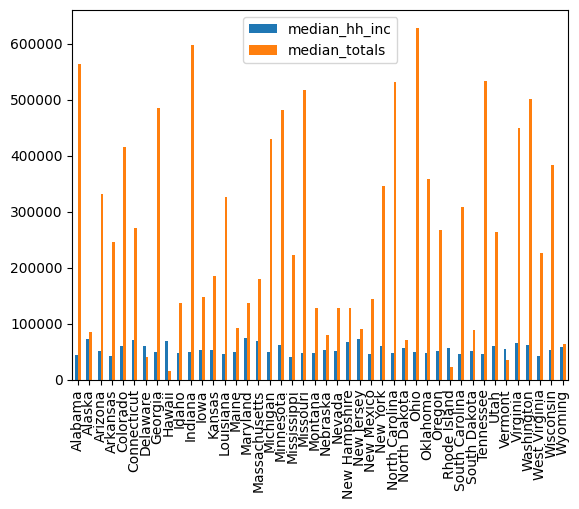

In [1420]:
df_trimmed.plot(kind='bar');

Lets also try sorting by `median_hh_inc`, descending to see if that reveals anything.

<Axes: >

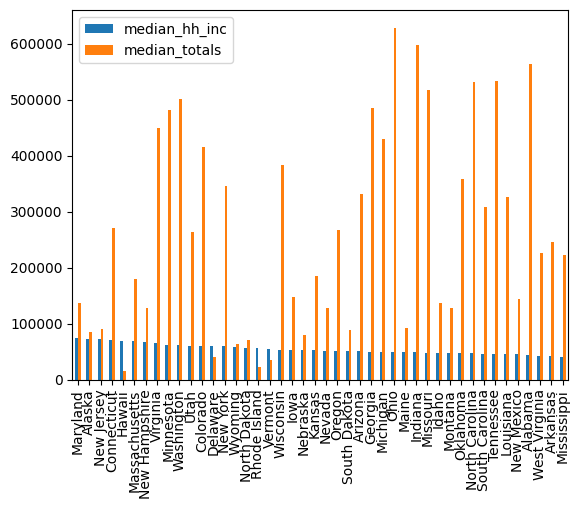

In [1421]:
df_trimmed.sort_values(by='median_hh_inc', ascending=False).plot(kind='bar')

There still appears to be no obvious correlation as the tops of the bar graphs rise and fall like a metropolitan skyline.

### Variance in the Proportion of Firearm Types and Potental Relations

For my second question, I wonder the following:

What does that look like when the NICS data is broken out to the different firearm types (`handgun`, `other`, `long gun`). 
  - Is the disparity between the three types generally the same across all of the states? 
  - Are certain states more like each other than others?
  - What factor does the population of veterans play in the average total number of NICS background checks for a given state?

We'll attack this one with a bar chart

I would assume a state like Rhode Island has a significantly smaller `long gun` background check percentage that somewhere like Wyoming, where recreational hunting is much more prominent.

I'm also curious if population has any sort of correlation. Are similarly populated states near each other in the average amount of checks for each firearm?

#### NICS Firearm Types

For this graph, we'll just take the average of each state for every month and year.

In [1422]:
df_nics_mean = df_nics.groupby('state').mean().round(0)

df_nics_mean = df_nics_mean.iloc[:, 4:7]  # grabbing only the data we care about.

# Change column names to make it more obvious that the values are averages
df_nics_mean.rename(columns=lambda x: x[:]+"_mean", inplace=True)

df_nics_mean.head(1)

handgun_mean  long_gun_mean  other_mean
state                                           
Alabama        9789.0        11568.0       174.0

When sorting highest to lowest on `long_gun_mean`, we find Pennsylvania at the top, followed by a sharp drop to Texas, then another sharp drop to California.. The drops between the values of each state greatly decreases once after passing the top 5.

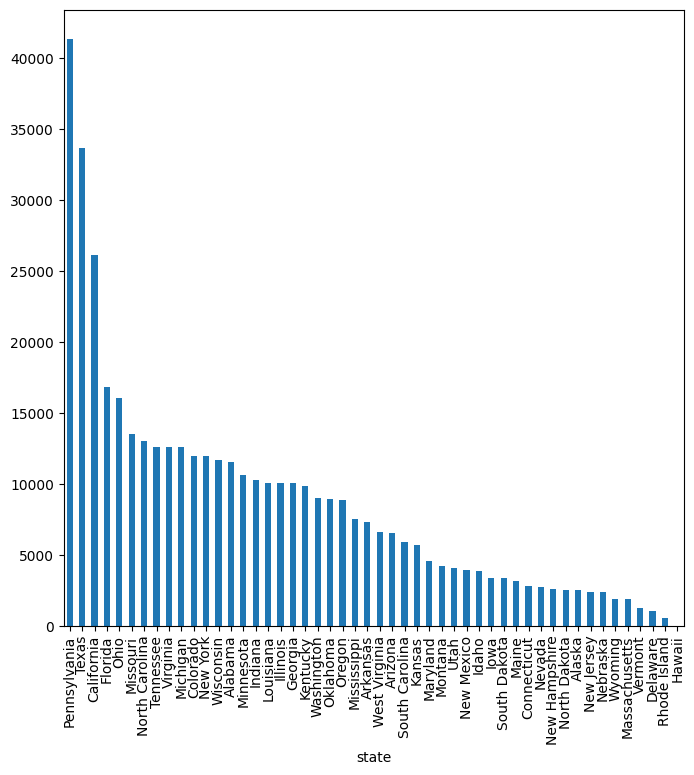

In [1423]:
df_nics_mean['long_gun_mean'].sort_values(ascending=False).plot(kind='bar', figsize=(8,8));

In terms of raw numbers, here they are below. To get them, we are grabbing solely the `long_gun_mean` column and calculating the delta and percent change and adding them as columns.

*About percent change:* we are adding a column for percent change using the built-in `DataFrame.pct_change()` method. This will allow us to view how extreme each decrease is in a more easily understood manner.

In [1424]:
df_long_gun = df_nics_mean.iloc[:, 1:2].sort_values(by='long_gun_mean', ascending=False)
df_long_gun['pct_change'] = df_long_gun['long_gun_mean'].pct_change().apply(lambda x: (x*100).__round__(1))
df_long_gun['delta'] = df_long_gun['long_gun_mean'].diff().shift(-1)  # calculate change from one column to the one below

df_long_gun.head(10)

long_gun_mean  pct_change   delta
state                                            
Pennsylvania          41338.0         NaN -7631.0
Texas                 33707.0       -18.5 -7554.0
California            26153.0       -22.4 -9285.0
Florida               16868.0       -35.5  -805.0
Ohio                  16063.0        -4.8 -2530.0
Missouri              13533.0       -15.8  -481.0
North Carolina        13052.0        -3.6  -425.0
Tennessee             12627.0        -3.3   -23.0
Virginia              12604.0        -0.2    -3.0
Michigan              12601.0        -0.0  -592.0

We can get an average of the delta to see the average "difference between each state" in regards to the number of `long_gun` background checks. We will use this while we investigate the level of disparity between firearm types.

In [1425]:
long_gun_mean_delta = df_long_gun['delta'].mean().__round__()
print(long_gun_mean_delta)

-844


We'll repeat what we did for `long_gun` to `handgun` and `other` so we can make some comparisons.

In [1426]:
df_handgun = df_nics_mean.iloc[:, 0:1].sort_values(by='handgun_mean', ascending=False)
df_handgun['pct_change'] = df_handgun['handgun_mean'].pct_change().apply(lambda x: (x*100).__round__(1))
df_handgun['delta'] = df_handgun['handgun_mean'].diff().shift(-1)  # calculate change from one column to the one below

df_handgun.head(10)

handgun_mean  pct_change   delta
state                                       
Texas            28607.0         NaN -2568.0
California       26039.0        -9.0    -4.0
Florida          26035.0        -0.0 -9333.0
Ohio             16702.0       -35.8 -2971.0
Tennessee        13731.0       -17.8 -1020.0
Virginia         12711.0        -7.4 -1573.0
Colorado         11138.0       -12.4  -411.0
Illinois         10727.0        -3.7   -72.0
Missouri         10655.0        -0.7  -866.0
Alabama           9789.0        -8.1  -180.0

This time, we see the top three states for `handgun` related checks as Texas, California, and Florida. Pennsylvania, the outlier and number one spot for `long_gun` related checks, comes in 12th.

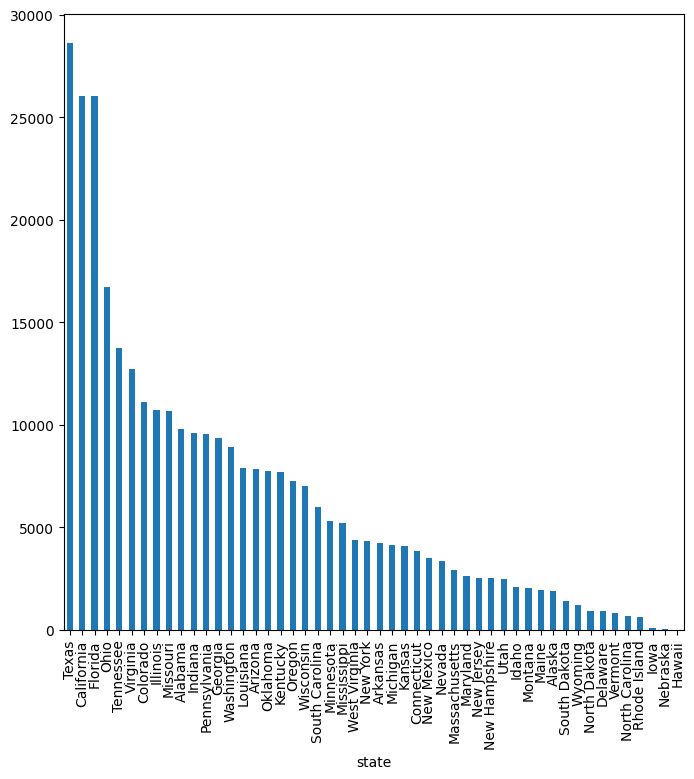

In [1427]:
df_nics_mean['handgun_mean'].sort_values(ascending=False).plot(kind='bar', figsize=(8,8));

Here, California swaps places with Texas with nearly double as many `other` checks, while Florida remains in 3rd. Pennsylvania, meanwhile, is in 42nd.

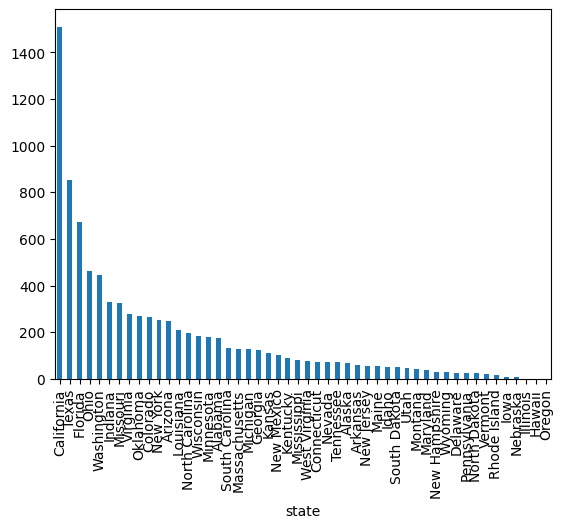

In [1428]:
df_nics_mean['other_mean'].sort_values(ascending=False).plot(kind='bar');

Here is the same thing as before, but now for the `other` firearm type.

In [ ]:
df_other = df_nics_mean.iloc[:, 2:3].sort_values(by='other_mean', ascending=False)
df_other['pct_change'] = df_other['other_mean'].pct_change().apply(lambda x: (x*100).__round__(1))  # convert to %-like representation instead of decimal
df_other['delta'] = df_other['other_mean'].diff().shift(-1)  # calculate change from one column to the one below

df_other.head(10)

other_mean  pct_change  delta
state                                    
California      1509.0         NaN -657.0
Texas            852.0       -43.5 -177.0
Florida          675.0       -20.8 -211.0
Ohio             464.0       -31.3  -19.0
Washington       445.0        -4.1 -114.0
Indiana          331.0       -25.6   -6.0
Missouri         325.0        -1.8  -45.0
Virginia         280.0       -13.8   -8.0
Oklahoma         272.0        -2.9   -6.0
Colorado         266.0        -2.2  -14.0

With this information, we can observe that California, Texas, Florida, Ohio, Missouri, and Virginia are consistently within the top 10. We also see that the disparity for a single type of firearm from 1st to 2nd is relatively high, with an average decrease of roughly 24% between the two states. Lets now compare throw population and landmass into the mix to see what further insight we can gain.

#### Geographical and Population Influences/Relationships

We'll get the indexes of the relevant `facts` using the previously defined `find_index()` function.

In [1430]:
pop_idx = find_index(df_census['Fact'], '(.*Population, Cen.*)')[0][0]  # == 3
land_idx = find_index(df_census['Fact'], '(.*Land area.*)')[0][0]       # == 63
print("Indexes\n========\n2010 population: " + str(pop_idx), "\nLandmass in sq. mi.: " + str(land_idx))


Indexes
2010 population: 3 
Landmass in sq. mi.: 63


Using those indexes, we can add two more columns to the firearm DataFrames.

In [1431]:
census_pop = df_census.iloc[pop_idx][1:]#.to_frame()
#census_pop.rename(columns={3: "population"}, inplace=True)
census_pop.head(1)

Alabama    4779736.0
Name: 3, dtype: object

In [1432]:
census_land = df_census.iloc[land_idx][1:]#.to_frame()
#census_land.rename(columns={63: "land_area_sq_mi"}, inplace=True)
census_land.head(1)

Alabama    50645.33
Name: 63, dtype: object

Now we'll do the joining to make our analysis a bit easier.

In [1433]:
df_nics_mean['population'] = census_pop
df_nics_mean['land_area_sq_mi'] = census_land

df_nics_mean.head(1)

handgun_mean  long_gun_mean  other_mean population land_area_sq_mi
state                                                                      
Alabama        9789.0        11568.0       174.0  4779736.0        50645.33

Now it's time to draw some graphs! With the `handgun` graph, we can see that there isn't an obvious relationship between the amount of landmass and number of background checks for `handgun`-related purposes.

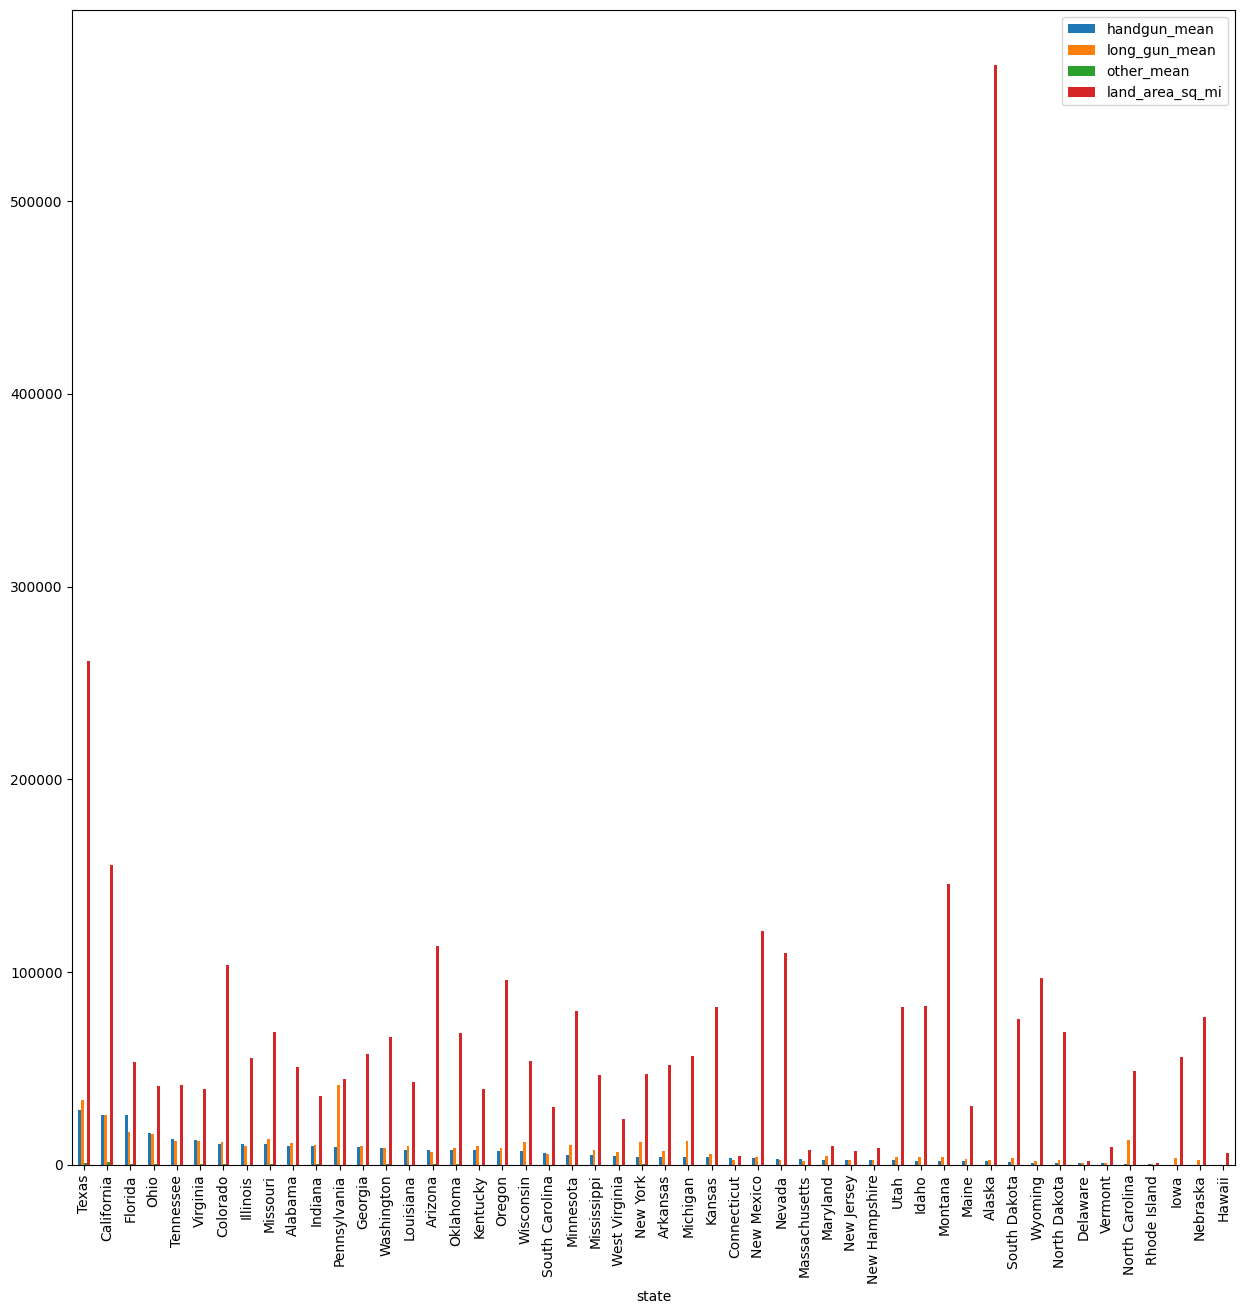

In [1434]:
df_nics_mean.loc[:, ['handgun_mean', 'long_gun_mean', 'other_mean', 'land_area_sq_mi']].sort_values(by='handgun_mean', ascending=False).plot(kind='bar', figsize=(15,15));

Well do the same, but sorting on `long_gun`-related checks.

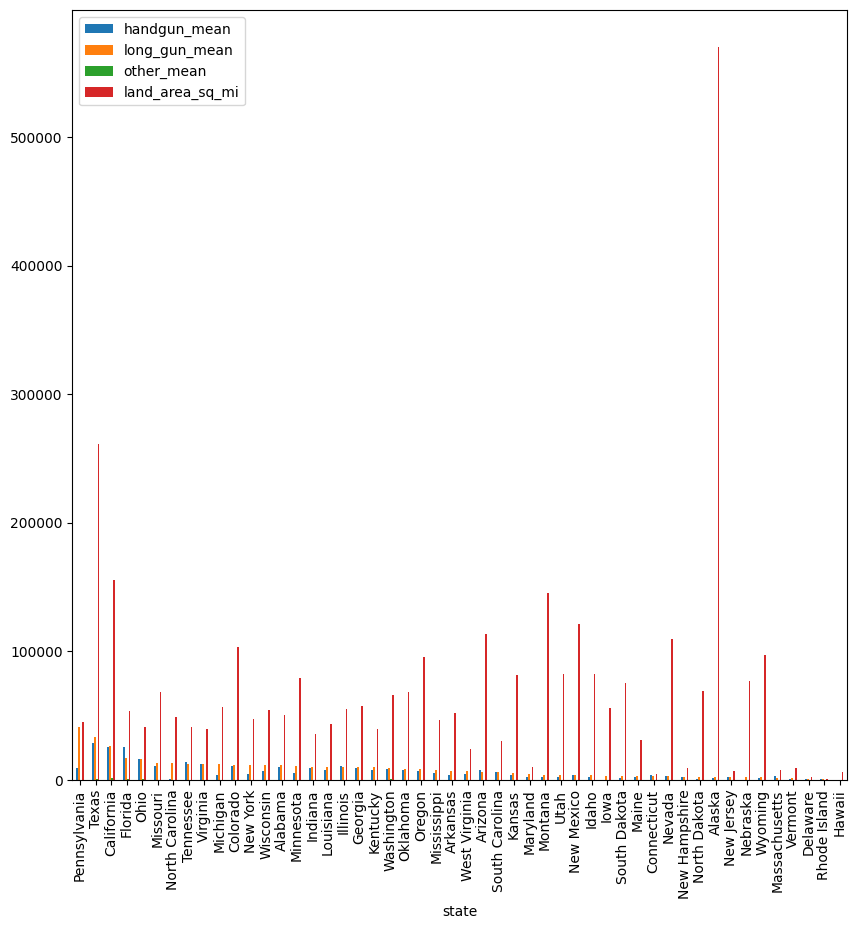

In [1435]:
df_nics_mean.loc[:, ['handgun_mean', 'long_gun_mean', 'other_mean', 'land_area_sq_mi']].sort_values(by='long_gun_mean', ascending=False).plot(kind='bar', figsize=(10,10));

And now `other`. With these three graphs, we can start looking for commonalities or anomalies to further our investigation into the question.

In [1436]:
df_nics_mean.loc[:, ['handgun_mean', 'long_gun_mean', 'other_mean', 'land_area_sq_mi']].sort_values(by='other_mean', ascending=False).plot(kind='bar', figsize=(10,10));

For this chart, we are sorting by land area in square miles to assist in answering if that has any correlation with the amount of NICS background checks per firearm type.

In [1437]:
df_nics_mean.loc[:, ['handgun_mean', 'long_gun_mean', 'other_mean', 'land_area_sq_mi']].sort_values(by='land_area_sq_mi', ascending=False).plot(kind='bar', figsize=(8,8));

There does not appear to be a relationship between land area and background checks for specific firearm types. Lets now check with population, doing effectively the same thing but swapping the `land_area_sq_mi` column for `population`.

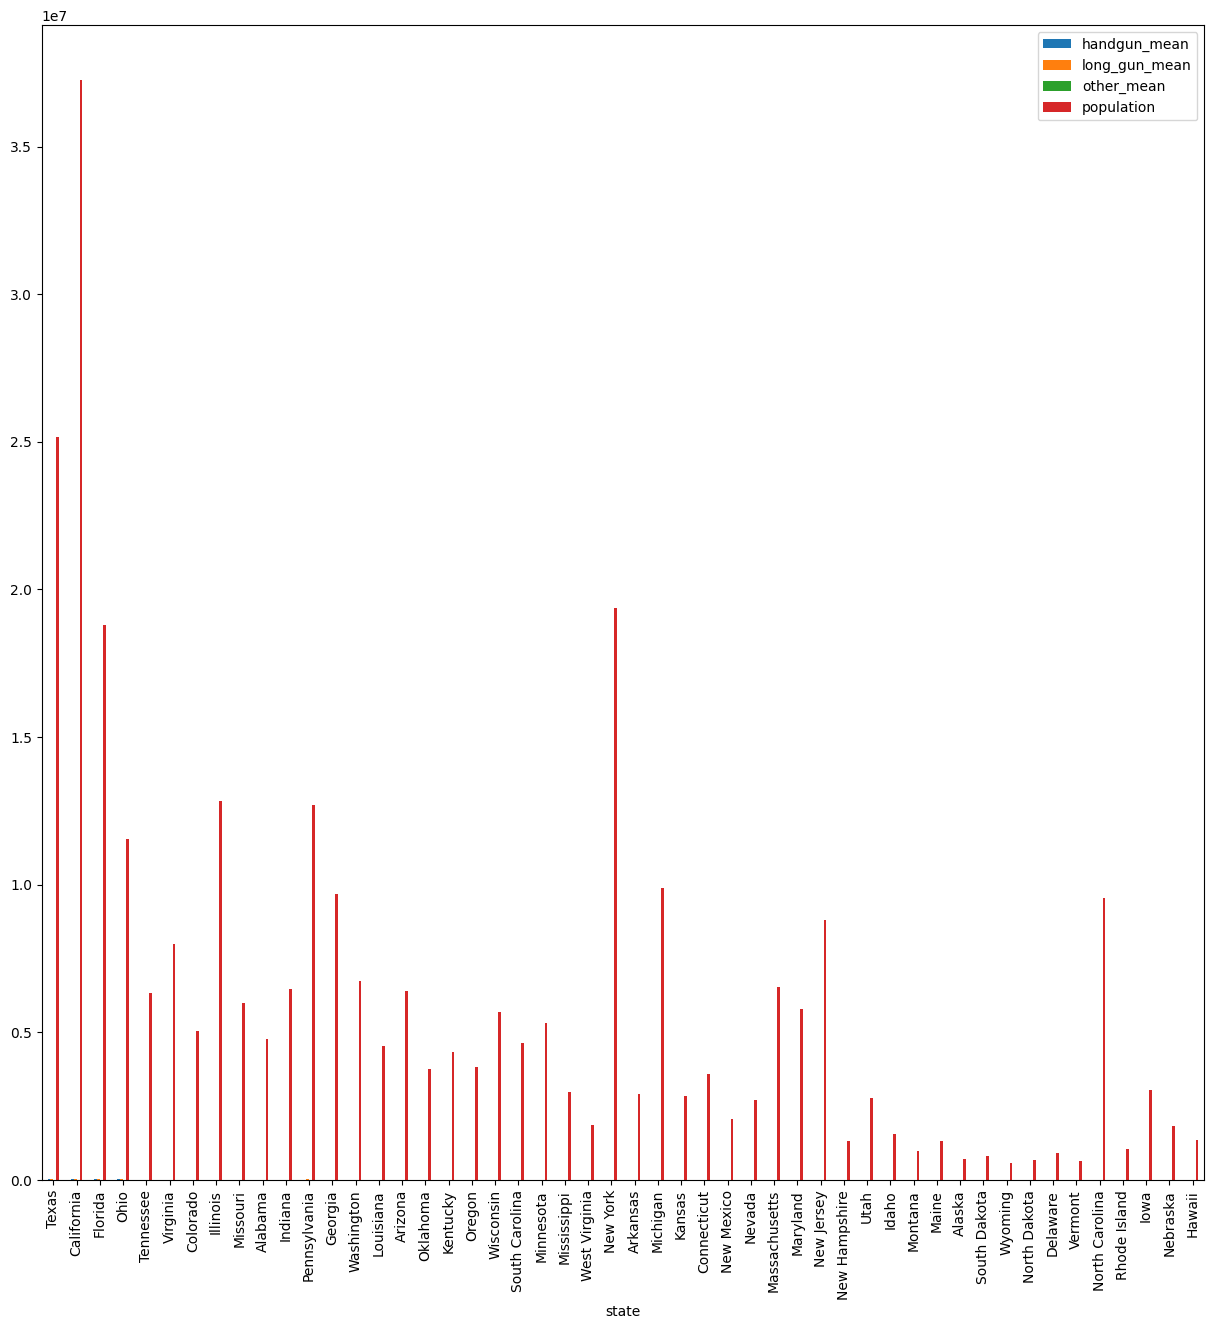

In [1438]:
df_nics_mean.loc[:, ['handgun_mean', 'long_gun_mean', 'other_mean', 'population']].sort_values(by='handgun_mean', ascending=False).plot(kind='bar', figsize=(15,15));

In [1439]:
df_nics_mean.loc[:, ['handgun_mean', 'long_gun_mean', 'other_mean', 'population']].sort_values(by='long_gun_mean', ascending=False).plot(kind='bar', figsize=(15,15));

In [1440]:
df_nics_mean.loc[:, ['handgun_mean', 'long_gun_mean', 'other_mean', 'population']].sort_values(by='other_mean', ascending=False).plot(kind='bar', figsize=(15,15));

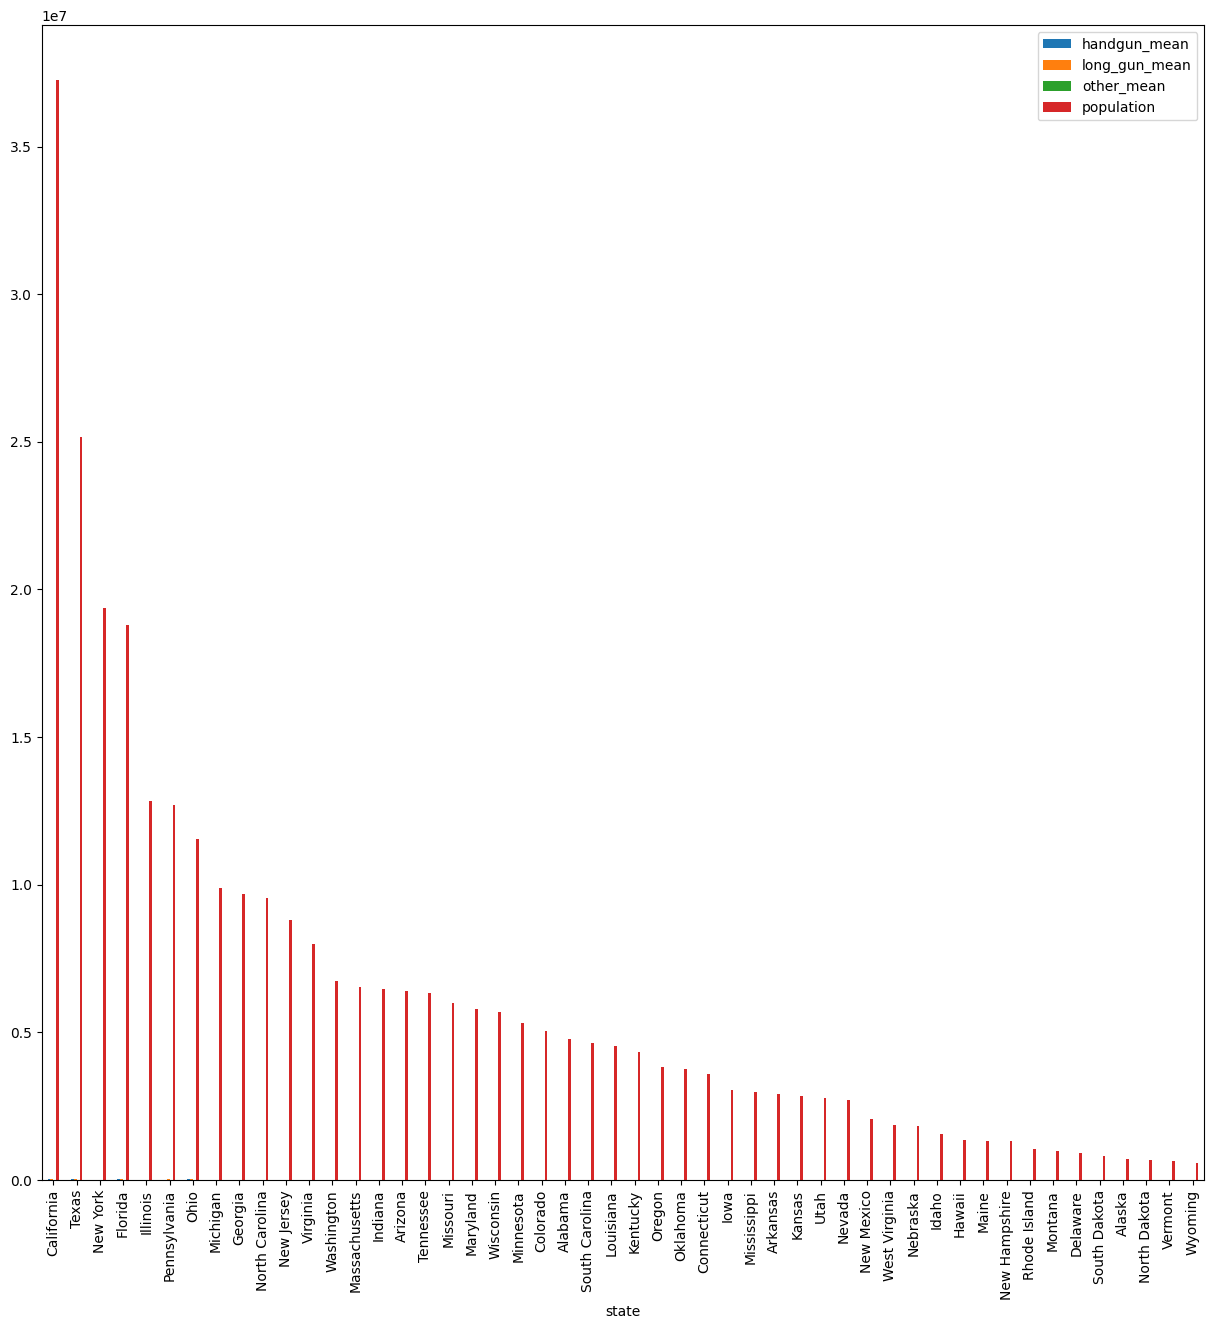

In [1441]:
df_nics_mean.loc[:, ['handgun_mean', 'long_gun_mean', 'other_mean', 'population']].sort_values(by='population', ascending=False).plot(kind='bar', figsize=(15,15));

Above we see the same few states in the top 10 again, namely Texas, California, and Florida. I'd like to do some comparisons to see what values are common between local charactersitics of a state and the types of firearm background checks. To do this, we'll create a few sets so we can perform a set intersection (more info: https://www.pythontutorial.net/python-basics/python-set-intersection/)

In [1442]:
area_top10 = set(df_nics_mean.sort_values(by='land_area_sq_mi', ascending=False).head(10).index.to_list())
pop_top10  = set(df_nics_mean.sort_values(by='population', ascending=False).head(10).index.to_list())
hgun_top10 = set(df_nics_mean.sort_values(by='handgun_mean', ascending=False).head(10).index.to_list())
lgun_top10 = set(df_nics_mean.sort_values(by='long_gun_mean', ascending=False).head(10).index.to_list())
ogun_top10 = set(df_nics_mean.sort_values(by='other_mean', ascending=False).head(10).index.to_list())

Between land area and population (local characteristics), the top 10 contains for both contains California and Texas. Between the three types of firearms, California, Texas, Virginia, Ohio, Missouri, and Florida are all shared in common.



In [1443]:
common_local = list(area_top10 & pop_top10)
common_gun = list(hgun_top10 & lgun_top10 & ogun_top10)

print(common_local)
print(common_gun)

['California', 'Texas']
['Ohio', 'Texas', 'Virginia', 'Missouri', 'Florida', 'California']


Finally, lets take a look at any potential relationship between the population of veterans and the number of background checks. For this, we will still break it up by firearm type. We'll make a column for `veterans` using the methods we previously used to extract portions of the Census data.

In [1444]:
vet_idx = find_index(df_census['Fact'], '(.*Veterans.*)')[0][0]

df_nics_mean['veterans'] = df_census.iloc[vet_idx][1:]

df_nics_mean.head(1)


handgun_mean  long_gun_mean  other_mean population land_area_sq_mi  \
state                                                                         
Alabama        9789.0        11568.0       174.0  4779736.0        50645.33   

         veterans  
state              
Alabama  363170.0

This graph looks quite similar to nearly all of the previous ones, with sharp drops plus a steady decline after the first few states.

In [1445]:
df_nics_mean.loc[:, ['veterans', 'handgun_mean', 'long_gun_mean', 'other_mean']].sort_values(by='veterans', ascending=False).plot(kind='bar', figsize=(10,10));

For all of the types of firearms defined in the NICS dataset, at least 50% of the top 10 states for firearm background checks are within the top 10 list for population of veterans.

This points to a correlation between the number of veterans and the number of background checks for firearm transactions. This is especially shown with the `long_gun` category, as it overlaps with 7 out of the top 10 most veteran-populated states.

In [1446]:
vet_top10 = set(df_nics_mean.sort_values(by='veterans', ascending=False).head(10).index)
print(list(vet_top10 & set(common_gun)))
print(list(vet_top10 & hgun_top10))  # 60% overlap
print(list(vet_top10 & ogun_top10))  # 50% overlap
print(list(vet_top10 & lgun_top10))  # 70% overlap

['Ohio', 'Texas', 'Virginia', 'Florida', 'California']
['Ohio', 'Illinois', 'Texas', 'Virginia', 'Florida', 'California']
['Ohio', 'Virginia', 'Texas', 'Florida', 'California']
['Ohio', 'North Carolina', 'Virginia', 'Pennsylvania', 'Texas', 'Florida', 'California']


<a id='conclusions'></a>
## Conclusions

The first question we sought to answer was if there is any correlation between median household income and the total number of NICS background checks for each state. After investigating this relationship with a scatter plot, no obvious correlation was found and the variance/scattered-ness between values appeared high.

For our second question, which was looking to find variance and commonalities in the proportion of firearm types and characteristics of the 50 United States, we came to the following as a possible conclusion: 

60% of the top 10 states for each three firearm types overlap between the three lists, which indicates that there is at least something about each of these states that is similar. One factor that appears to be most similar between those states is the relatively high population of veterans. The greatest overlap between seen was 70% of the states were the same between top 10 states by `long_gun` background checks and by veteran population. No obvious correlations were determined when reviewing a state's overall population, nor its land area. There was only a 20% overlap between those factors' top 10 states and the top 10 states for each firearm type.

The most prevalent states in regards to the top 10 most NICS background checks, population, and land area were California and Texas. These two states showed up in every top 10 list generated in investigating the data for our second question.

More research in the relationship between other census "facts" and the quantity of background checks would be prudent. It may also be worth doing the reverse of what I did, by instead looking for what may correlate with a low amount of background checks. This statistic could either point to states that underutilize NICS or simply have fewer firearm transactions.

Another useful calculation would be background check per capita, in total and for each firearm type. This can be used to compare and contrast against the same variables I utilized and can enable further insight into possible relationships.

Further data that could be useful in determining reasons why some states have certain firearms that are more common than others includes hunting season registration data (number of rifles/shotguns registered, etc.), carry permit holder statistics (quantity per state), number of firearm stores and shooting ranges in each state (calculate stores/ranges per square mile), population density. 

Some limitations the exploration of these NICS and Census datasets are:
- Statistical methods were not applied (unless accidentally), as I do not have not yet learned about them so far in university (soon, that will change).
- Outliers were not discarded or handled in any other way.
  - Calculated means/medians are skewed, which greatly affects at least the appearance of the charts and what states appear in the top 10 list. Both of those impacts directly effect my conclusion to the second question.
- It is possible that weapons can be rented by an individual from another state, thus triggering a background check. That individual effectively counts towards the population of the "home" state, but adds to the rental statistic of another state's.
- States utilize NICS differently and those nuances are not documented in the data (understandably). For example, Kentucky performs background checks on concealed carry license holders monthly, while most other states do not (Source: https://www.thetrace.org/2015/11/black-friday-gun-sales-background-checks/). This show Kentucky as a massive outlier and makes their data less useful, which hinders accuracy in reporting and calculation.

In [1449]:
# Running this cell will execute a bash command to convert this notebook to an .html file
!python -m nbconvert --to html Investigate_a_Dataset.ipynb

[NbConvertApp] Converting notebook Investigate_a_Dataset.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 17 image(s).
[NbConvertApp] Writing 1871171 bytes to Investigate_a_Dataset.html
